<a href="https://colab.research.google.com/github/Bulat27/topological-features-influence-GNNs/blob/master/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch.nn.functional as F

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 66.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Load and inspect the dataset


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_classes = dataset.num_classes

Processing...
Done!


In [3]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [4]:
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
print(data.train_mask.sum().item())
print(data.val_mask.sum().item())
print(data.test_mask.sum().item())

140
500
1000


In [6]:
print(dataset.num_features)
print(data.num_features)

1433
1433


# GAT architecture


In [7]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, data, hidden_channels, heads):
        super().__init__()
        # torch.manual_seed(42)
        self.conv1 = GATConv(in_channels=data.num_features, out_channels=hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(in_channels=hidden_channels*heads, out_channels=num_classes, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Model functions

In [8]:
def train(model, data, optimizer, criterion):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      pred = out.argmax(dim=1)
      correct = pred[data.train_mask] == data.y[data.train_mask]
      acc = int(correct.sum()) / int(data.train_mask.sum())
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return acc, loss.item()

In [9]:
def eval(model, data, data_mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[data_mask] == data.y[data_mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(data_mask.sum())  # Derive ratio of correct predictions.
      loss = criterion(out[data_mask], data.y[data_mask])
      return acc, loss.item()

In [10]:
def model_training(n_epochs, model, data, optimizer, criterion):
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  best_val_acc = 0.0
  best_epoch = 0

  for epoch in range(1, n_epochs + 1):
    train_acc, train_loss = train(model, data, optimizer, criterion)
    val_acc, val_loss = eval(model, data, data.val_mask)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  return train_losses, train_accs, val_losses, val_accs, best_epoch

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(n_epochs, train_losses, train_accs, val_losses, val_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, val_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, val_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

# Performance without topological features

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0]
data = data.to(device)
model = GAT(data, hidden_channels=8, heads=8)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
n_epochs = 200

train_losses, train_accs, val_losses, val_accs, best_epoch = model_training(n_epochs, model, data, optimizer, criterion)

Epoch: 001, Train Loss: 1.9440, Val Loss: 1.9368
Epoch: 002, Train Loss: 1.9383, Val Loss: 1.9318
Epoch: 003, Train Loss: 1.9337, Val Loss: 1.9279
Epoch: 004, Train Loss: 1.9213, Val Loss: 1.9226
Epoch: 005, Train Loss: 1.9178, Val Loss: 1.9187
Epoch: 006, Train Loss: 1.9119, Val Loss: 1.9151
Epoch: 007, Train Loss: 1.9078, Val Loss: 1.9120
Epoch: 008, Train Loss: 1.9031, Val Loss: 1.9076
Epoch: 009, Train Loss: 1.8869, Val Loss: 1.9031
Epoch: 010, Train Loss: 1.8881, Val Loss: 1.8989
Epoch: 011, Train Loss: 1.8841, Val Loss: 1.8958
Epoch: 012, Train Loss: 1.8752, Val Loss: 1.8927
Epoch: 013, Train Loss: 1.8632, Val Loss: 1.8892
Epoch: 014, Train Loss: 1.8584, Val Loss: 1.8856
Epoch: 015, Train Loss: 1.8485, Val Loss: 1.8815
Epoch: 016, Train Loss: 1.8365, Val Loss: 1.8773
Epoch: 017, Train Loss: 1.8230, Val Loss: 1.8726
Epoch: 018, Train Loss: 1.8033, Val Loss: 1.8683
Epoch: 019, Train Loss: 1.7949, Val Loss: 1.8623
Epoch: 020, Train Loss: 1.7892, Val Loss: 1.8561
Epoch: 021, Train Lo

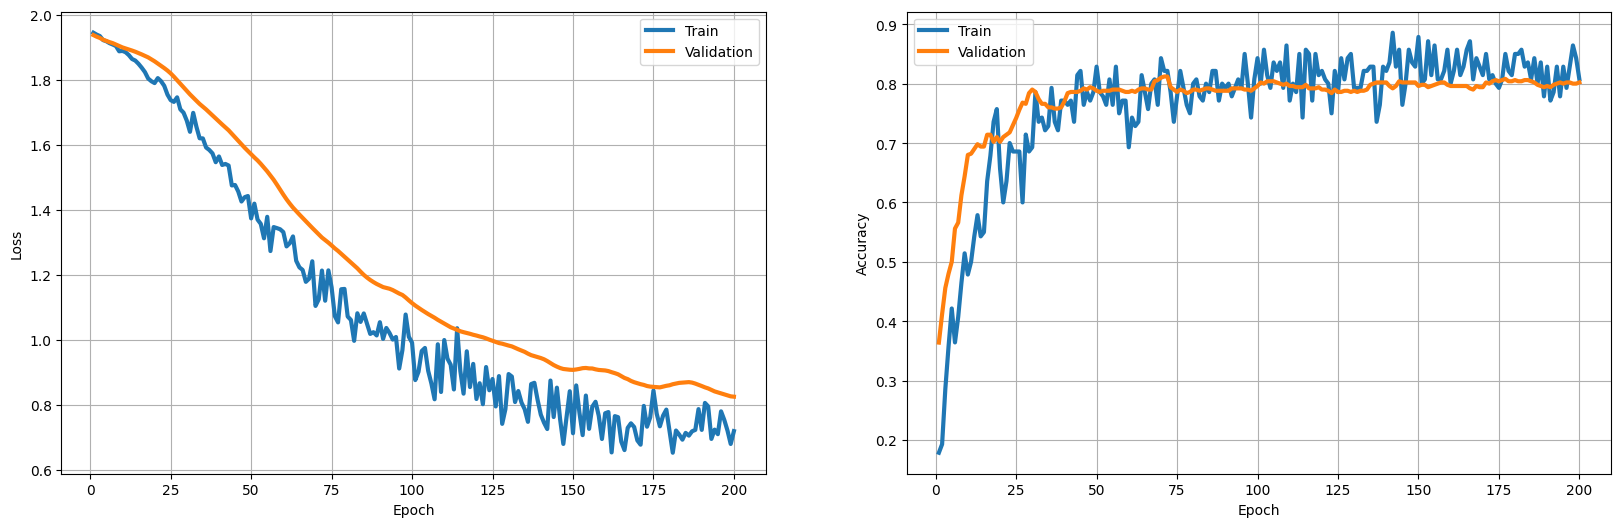

In [47]:
plot_results(n_epochs,train_losses,train_accs,val_losses,val_accs)

In [48]:
print(best_epoch)

71


In [49]:
model.load_state_dict(torch.load('best_model.pth'))

test_acc,_ = eval(model, data, data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8260


# Adding topological features

In [16]:
import networkx as nx
import torch_geometric

In [17]:
def concatenate_features(data_x, *args):
  data_x_list = data_x.tolist()
  for i in range(len(data_x_list)):
    for arg in args:
      data_x_list[i].append(arg[i])

  return torch.tensor(data_x_list)

In [18]:
G = torch_geometric.utils.to_networkx(data)

cc = nx.closeness_centrality(G)
bc = nx.betweenness_centrality(G)
dc = nx.degree_centrality(G)
ec = nx.eigenvector_centrality(G)

new_x = concatenate_features(data.x, cc, bc, dc, ec)

In [19]:
from torch_geometric.data import Data

new_data = Data(x=new_x, edge_index=data.edge_index, y=data.y, train_mask=data.train_mask, val_mask=data.val_mask, test_mask=data.test_mask)
print(new_data)

Data(x=[2708, 1437], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# GAT with topological features

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_data = new_data.to(device)
new_model = GAT(new_data, hidden_channels=8, heads=8)
new_model = new_model.to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
n_epochs = 200

train_losses, train_accs, val_losses, val_accs, best_epoch = model_training(n_epochs, new_model, new_data, optimizer, criterion)

Epoch: 001, Train Loss: 1.9452, Val Loss: 1.9359
Epoch: 002, Train Loss: 1.9359, Val Loss: 1.9285
Epoch: 003, Train Loss: 1.9285, Val Loss: 1.9232
Epoch: 004, Train Loss: 1.9243, Val Loss: 1.9199
Epoch: 005, Train Loss: 1.9170, Val Loss: 1.9173
Epoch: 006, Train Loss: 1.9085, Val Loss: 1.9140
Epoch: 007, Train Loss: 1.9012, Val Loss: 1.9103
Epoch: 008, Train Loss: 1.8861, Val Loss: 1.9060
Epoch: 009, Train Loss: 1.8961, Val Loss: 1.9003
Epoch: 010, Train Loss: 1.8758, Val Loss: 1.8941
Epoch: 011, Train Loss: 1.8800, Val Loss: 1.8875
Epoch: 012, Train Loss: 1.8660, Val Loss: 1.8810
Epoch: 013, Train Loss: 1.8580, Val Loss: 1.8750
Epoch: 014, Train Loss: 1.8547, Val Loss: 1.8690
Epoch: 015, Train Loss: 1.8377, Val Loss: 1.8627
Epoch: 016, Train Loss: 1.8235, Val Loss: 1.8568
Epoch: 017, Train Loss: 1.8073, Val Loss: 1.8504
Epoch: 018, Train Loss: 1.8023, Val Loss: 1.8440
Epoch: 019, Train Loss: 1.8044, Val Loss: 1.8375
Epoch: 020, Train Loss: 1.7670, Val Loss: 1.8312
Epoch: 021, Train Lo

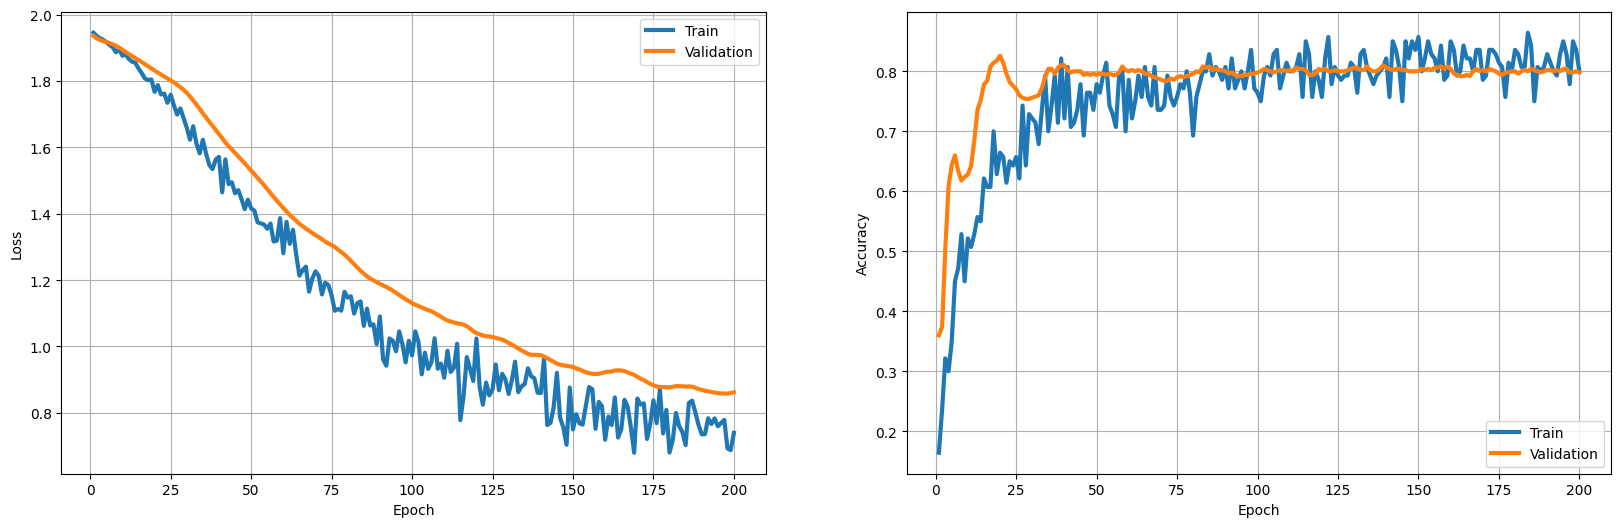

In [21]:
plot_results(n_epochs, train_losses, train_accs, val_losses, val_accs)

In [22]:
new_model.load_state_dict(torch.load('best_model.pth'))

test_acc, _ = eval(new_model, new_data, new_data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8030


# Comparison

In [50]:
def run(n_runs, data):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  criterion = torch.nn.CrossEntropyLoss()
  n_epochs = 200
  data = data.to(device)
  test_accs = []

  for i in range(1 , n_runs+1):
    print(f"\n RUN: {i}\n")

    model = GAT(data, hidden_channels=8, heads=8)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    train_losses, train_accs, val_losses, val_accs, best_epoch = model_training(n_epochs, model, data, optimizer, criterion)

    model.load_state_dict(torch.load('best_model.pth'))
    test_acc, _  = eval(model, data, data.test_mask)
    test_accs.append(test_acc)

  return sum(test_accs) / len(test_accs)

In [51]:
avg_acc = run(10, data)
avg_acc_new = run(10, new_data)

print(f'Avg test acc original data: {avg_acc}')
print(f'Avg test acc new data:{avg_acc_new}')


 RUN: 1

Epoch: 001, Train Loss: 1.9444, Val Loss: 1.9456
Epoch: 002, Train Loss: 1.9408, Val Loss: 1.9407
Epoch: 003, Train Loss: 1.9325, Val Loss: 1.9363
Epoch: 004, Train Loss: 1.9271, Val Loss: 1.9307
Epoch: 005, Train Loss: 1.9227, Val Loss: 1.9260
Epoch: 006, Train Loss: 1.9077, Val Loss: 1.9218
Epoch: 007, Train Loss: 1.9114, Val Loss: 1.9172
Epoch: 008, Train Loss: 1.8980, Val Loss: 1.9128
Epoch: 009, Train Loss: 1.8951, Val Loss: 1.9081
Epoch: 010, Train Loss: 1.8838, Val Loss: 1.9032
Epoch: 011, Train Loss: 1.8781, Val Loss: 1.8992
Epoch: 012, Train Loss: 1.8594, Val Loss: 1.8958
Epoch: 013, Train Loss: 1.8620, Val Loss: 1.8918
Epoch: 014, Train Loss: 1.8558, Val Loss: 1.8875
Epoch: 015, Train Loss: 1.8325, Val Loss: 1.8838
Epoch: 016, Train Loss: 1.8315, Val Loss: 1.8795
Epoch: 017, Train Loss: 1.8283, Val Loss: 1.8743
Epoch: 018, Train Loss: 1.8183, Val Loss: 1.8684
Epoch: 019, Train Loss: 1.8204, Val Loss: 1.8616
Epoch: 020, Train Loss: 1.8098, Val Loss: 1.8530
Epoch: 021